## Gas Product Type Prediction

Given *weekly reports of gas sales*, let's try to classify the **type** of a given product.

We will use a TensorFlow ANN to make our predictions.

Data source: https://www.kaggle.com/datasets/matheusfreitag/gas-prices-in-brazil

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import tensorflow as tf

2025-06-11 09:03:44.386500: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv('2004-2021.tsv', delimiter='\t')
data

,DATA INICIAL,DATA FINAL,REGIÃO,ESTADO,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO
0,2004-05-09,2004-05-15,CENTRO OESTE,DISTRITO FEDERAL,ETANOL HIDRATADO,127,R$/l,1.288,0.016,1.190,1.350,0.463,0.012,0.825,0.11,0.4201,0.9666,0.133
1,2004-05-09,2004-05-15,CENTRO OESTE,GOIAS,ETANOL HIDRATADO,387,R$/l,1.162,0.114,0.890,1.449,0.399,0.098,0.763,0.088,0.5013,1.05,0.115
2,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO,ETANOL HIDRATADO,192,R$/l,1.389,0.097,1.180,1.760,0.419,0.070,0.97,0.095,0.5614,1.161,0.098
3,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO DO SUL,ETANOL HIDRATADO,162,R$/l,1.262,0.070,1.090,1.509,0.432,0.055,0.83,0.119,0.5991,1.22242,0.143
4,2004-05-09,2004-05-15,NORDESTE,ALAGOAS,ETANOL HIDRATADO,103,R$/l,1.181,0.078,1.050,1.400,0.24,0.066,0.941,0.077,0.7441,1.0317,0.082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120818,2021-04-25,2021-05-01,NORTE,RORAIMA,OLEO DIESEL S10,12,R$/l,4.582,0.056,4.510,4.690,-99999.0,0.012,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0
120819,2021-04-25,2021-05-01,SUL,SANTA CATARINA,OLEO DIESEL S10,100,R$/l,4.141,0.187,3.838,4.739,-99999.0,0.045,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0
120820,2021-04-25,2021-05-01,SUDESTE,SAO PAULO,OLEO DIESEL S10,886,R$/l,4.246,0.216,3.769,5.199,-99999.0,0.051,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0
120821,2021-04-25,2021-05-01,NORDESTE,SERGIPE,OLEO DIESEL S10,33,R$/l,4.464,0.205,4.190,4.699,-99999.0,0.046,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120823 entries, 0 to 120822
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   DATA INICIAL                   120823 non-null  object 
 1   DATA FINAL                     120823 non-null  object 
 2   REGIÃO                         120823 non-null  object 
 3   ESTADO                         120823 non-null  object 
 4   PRODUTO                        120823 non-null  object 
 5   NÚMERO DE POSTOS PESQUISADOS   120823 non-null  int64  
 6   UNIDADE DE MEDIDA              120823 non-null  object 
 7   PREÇO MÉDIO REVENDA            120823 non-null  float64
 8   DESVIO PADRÃO REVENDA          120823 non-null  float64
 9   PREÇO MÍNIMO REVENDA           120823 non-null  float64
 10  PREÇO MÁXIMO REVENDA           120823 non-null  float64
 11  MARGEM MÉDIA REVENDA           120823 non-null  object 
 12  COEF DE VARIAÇÃO REVENDA      

### Cleaning

In [4]:
data.isna().sum()

DATA INICIAL                     0
DATA FINAL                       0
REGIÃO                           0
ESTADO                           0
PRODUTO                          0
NÚMERO DE POSTOS PESQUISADOS     0
UNIDADE DE MEDIDA                0
PREÇO MÉDIO REVENDA              0
DESVIO PADRÃO REVENDA            0
PREÇO MÍNIMO REVENDA             0
PREÇO MÁXIMO REVENDA             0
MARGEM MÉDIA REVENDA             0
COEF DE VARIAÇÃO REVENDA         0
PREÇO MÉDIO DISTRIBUIÇÃO         0
DESVIO PADRÃO DISTRIBUIÇÃO       0
PREÇO MÍNIMO DISTRIBUIÇÃO        0
PREÇO MÁXIMO DISTRIBUIÇÃO        0
COEF DE VARIAÇÃO DISTRIBUIÇÃO    0
dtype: int64

In [5]:
data['Year'] = data['DATA INICIAL'].apply(lambda x: int(x[0:4]))
data['Month'] = data['DATA FINAL'].apply(lambda x: int(x[5:7]))

In [6]:
data = data.drop(['DATA INICIAL', 'DATA FINAL'], axis=1)
data

,REGIÃO,ESTADO,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO,Year,Month
0,CENTRO OESTE,DISTRITO FEDERAL,ETANOL HIDRATADO,127,R$/l,1.288,0.016,1.190,1.350,0.463,0.012,0.825,0.11,0.4201,0.9666,0.133,2004,5
1,CENTRO OESTE,GOIAS,ETANOL HIDRATADO,387,R$/l,1.162,0.114,0.890,1.449,0.399,0.098,0.763,0.088,0.5013,1.05,0.115,2004,5
2,CENTRO OESTE,MATO GROSSO,ETANOL HIDRATADO,192,R$/l,1.389,0.097,1.180,1.760,0.419,0.070,0.97,0.095,0.5614,1.161,0.098,2004,5
3,CENTRO OESTE,MATO GROSSO DO SUL,ETANOL HIDRATADO,162,R$/l,1.262,0.070,1.090,1.509,0.432,0.055,0.83,0.119,0.5991,1.22242,0.143,2004,5
4,NORDESTE,ALAGOAS,ETANOL HIDRATADO,103,R$/l,1.181,0.078,1.050,1.400,0.24,0.066,0.941,0.077,0.7441,1.0317,0.082,2004,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120818,NORTE,RORAIMA,OLEO DIESEL S10,12,R$/l,4.582,0.056,4.510,4.690,-99999.0,0.012,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,2021,5
120819,SUL,SANTA CATARINA,OLEO DIESEL S10,100,R$/l,4.141,0.187,3.838,4.739,-99999.0,0.045,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,2021,5
120820,SUDESTE,SAO PAULO,OLEO DIESEL S10,886,R$/l,4.246,0.216,3.769,5.199,-99999.0,0.051,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,2021,5
120821,NORDESTE,SERGIPE,OLEO DIESEL S10,33,R$/l,4.464,0.205,4.190,4.699,-99999.0,0.046,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,2021,5


### Class Visualization

In [7]:
data['PRODUTO'].value_counts()

PRODUTO
GASOLINA COMUM        23570
GLP                   23561
ETANOL HIDRATADO      23440
ÓLEO DIESEL           21194
GNV                   14469
ÓLEO DIESEL S10        9113
OLEO DIESEL S10        2376
OLEO DIESEL            2351
GASOLINA ADITIVADA      749
Name: count, dtype: int64

In [8]:
duplicate_values = {'OLEO DIESEL': 'ÓLEO DIESEL', 'OLEO DIESEL S10': 'ÓLEO DIESEL S10'}
data['PRODUTO'] = data['PRODUTO'].replace(duplicate_values)

In [9]:
# Dropping rows with 'GASOLINA ADITIVADA' values in the PRODUTO column
data = data.drop(data[data['PRODUTO'] == 'GASOLINA ADITIVADA'].index, axis=0).reset_index(drop=True)
data['PRODUTO'].value_counts()

PRODUTO
GASOLINA COMUM      23570
GLP                 23561
ÓLEO DIESEL         23545
ETANOL HIDRATADO    23440
GNV                 14469
ÓLEO DIESEL S10     11489
Name: count, dtype: int64

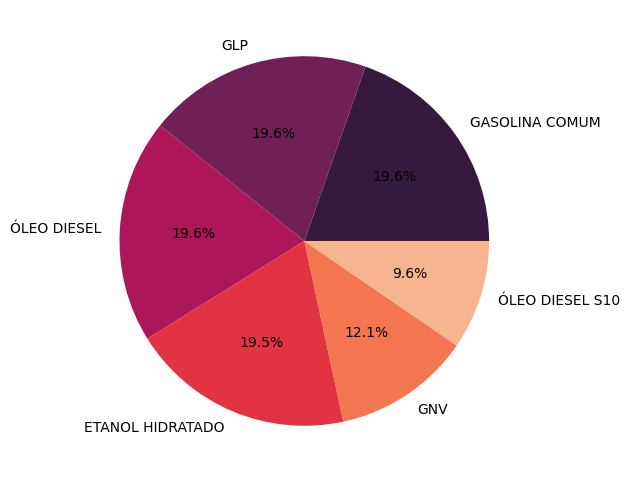

In [10]:
plt.figure(figsize=(6, 6))
plt.pie(
    x = data['PRODUTO'].value_counts(),
    labels = data['PRODUTO'].value_counts().index,
    autopct = "%.1f%%",
    colors = sns.color_palette('rocket')
)
plt.show()

#### Encoding

In [11]:
data

,REGIÃO,ESTADO,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO,Year,Month
0,CENTRO OESTE,DISTRITO FEDERAL,ETANOL HIDRATADO,127,R$/l,1.288,0.016,1.190,1.350,0.463,0.012,0.825,0.11,0.4201,0.9666,0.133,2004,5
1,CENTRO OESTE,GOIAS,ETANOL HIDRATADO,387,R$/l,1.162,0.114,0.890,1.449,0.399,0.098,0.763,0.088,0.5013,1.05,0.115,2004,5
2,CENTRO OESTE,MATO GROSSO,ETANOL HIDRATADO,192,R$/l,1.389,0.097,1.180,1.760,0.419,0.070,0.97,0.095,0.5614,1.161,0.098,2004,5
3,CENTRO OESTE,MATO GROSSO DO SUL,ETANOL HIDRATADO,162,R$/l,1.262,0.070,1.090,1.509,0.432,0.055,0.83,0.119,0.5991,1.22242,0.143,2004,5
4,NORDESTE,ALAGOAS,ETANOL HIDRATADO,103,R$/l,1.181,0.078,1.050,1.400,0.24,0.066,0.941,0.077,0.7441,1.0317,0.082,2004,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120069,NORTE,RORAIMA,ÓLEO DIESEL S10,12,R$/l,4.582,0.056,4.510,4.690,-99999.0,0.012,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,2021,5
120070,SUL,SANTA CATARINA,ÓLEO DIESEL S10,100,R$/l,4.141,0.187,3.838,4.739,-99999.0,0.045,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,2021,5
120071,SUDESTE,SAO PAULO,ÓLEO DIESEL S10,886,R$/l,4.246,0.216,3.769,5.199,-99999.0,0.051,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,2021,5
120072,NORDESTE,SERGIPE,ÓLEO DIESEL S10,33,R$/l,4.464,0.205,4.190,4.699,-99999.0,0.046,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,2021,5


In [12]:
label_encoder = LabelEncoder()

data['PRODUTO'] = label_encoder.fit_transform(data['PRODUTO'])

In [13]:
dict(enumerate(label_encoder.classes_))

{0: 'ETANOL HIDRATADO',
 1: 'GASOLINA COMUM',
 2: 'GLP',
 3: 'GNV',
 4: 'ÓLEO DIESEL',
 5: 'ÓLEO DIESEL S10'}

In [14]:
{column: list(data[column].unique()) for column in data.columns if data.dtypes[column] == 'object'}

{'REGIÃO': ['CENTRO OESTE', 'NORDESTE', 'NORTE', 'SUDESTE', 'SUL'],
 'ESTADO': ['DISTRITO FEDERAL',
  'GOIAS',
  'MATO GROSSO',
  'MATO GROSSO DO SUL',
  'ALAGOAS',
  'BAHIA',
  'CEARA',
  'MARANHAO',
  'PARAIBA',
  'PERNAMBUCO',
  'PIAUI',
  'RIO GRANDE DO NORTE',
  'SERGIPE',
  'ACRE',
  'AMAPA',
  'AMAZONAS',
  'PARA',
  'RONDONIA',
  'RORAIMA',
  'TOCANTINS',
  'ESPIRITO SANTO',
  'MINAS GERAIS',
  'RIO DE JANEIRO',
  'SAO PAULO',
  'PARANA',
  'RIO GRANDE DO SUL',
  'SANTA CATARINA'],
 'UNIDADE DE MEDIDA': ['R$/l', 'R$/13Kg', 'R$/m3'],
 'MARGEM MÉDIA REVENDA': ['0.463',
  '0.399',
  '0.419',
  '0.432',
  '0.24',
  '0.426',
  '0.353',
  '0.515',
  '0.277',
  '0.494',
  '0.332',
  '0.321',
  '0.689',
  '0.412',
  '0.441',
  '0.536',
  '0.533',
  '0.202',
  '0.546',
  '0.267',
  '0.389',
  '0.312',
  '0.198',
  '0.255',
  '0.416',
  '0.448',
  '0.421',
  '0.401',
  '0.428',
  '0.257',
  '0.413',
  '0.347',
  '0.529',
  '0.367',
  '0.286',
  '0.489',
  '0.335',
  '0.311',
  '0.693',
 

In [15]:
def onehot_encode(df, columns, prefixes):
    df = df.copy()
    for column, prefix in zip(columns, prefixes):
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [16]:
data = onehot_encode(
    data,
    ['REGIÃO',
    'ESTADO',
    'UNIDADE DE MEDIDA'],
    ['R', 'E', 'U']
)

In [17]:
data

,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO,Year,Month,R_CENTRO OESTE,R_NORDESTE,R_NORTE,R_SUDESTE,R_SUL,E_ACRE,E_ALAGOAS,E_AMAPA,E_AMAZONAS,E_BAHIA,E_CEARA,E_DISTRITO FEDERAL,E_ESPIRITO SANTO,E_GOIAS,E_MARANHAO,E_MATO GROSSO,E_MATO GROSSO DO SUL,E_MINAS GERAIS,E_PARA,E_PARAIBA,E_PARANA,E_PERNAMBUCO,E_PIAUI,E_RIO DE JANEIRO,E_RIO GRANDE DO NORTE,E_RIO GRANDE DO SUL,E_RONDONIA,E_RORAIMA,E_SANTA CATARINA,E_SAO PAULO,E_SERGIPE,E_TOCANTINS,U_R$/13Kg,U_R$/l,U_R$/m3
0,0,127,1.288,0.016,1.190,1.350,0.463,0.012,0.825,0.11,0.4201,0.9666,0.133,2004,5,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,0,387,1.162,0.114,0.890,1.449,0.399,0.098,0.763,0.088,0.5013,1.05,0.115,2004,5,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,0,192,1.389,0.097,1.180,1.760,0.419,0.070,0.97,0.095,0.5614,1.161,0.098,2004,5,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,0,162,1.262,0.070,1.090,1.509,0.432,0.055,0.83,0.119,0.5991,1.22242,0.143,2004,5,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,0,103,1.181,0.078,1.050,1.400,0.24,0.066,0.941,0.077,0.7441,1.0317,0.082,2004,5,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120069,5,12,4.582,0.056,4.510,4.690,-99999.0,0.012,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,2021,5,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False
120070,5,100,4.141,0.187,3.838,4.739,-99999.0,0.045,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,2021,5,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
120071,5,886,4.246,0.216,3.769,5.199,-99999.0,0.051,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,2021,5,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
120072,5,33,4.464,0.205,4.190,4.699,-99999.0,0.046,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,2021,5,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False


##### Finding Missing Values

In [19]:
data.isin(['-']).sum()

PRODUTO                             0
NÚMERO DE POSTOS PESQUISADOS        0
PREÇO MÉDIO REVENDA                 0
DESVIO PADRÃO REVENDA               0
PREÇO MÍNIMO REVENDA                0
PREÇO MÁXIMO REVENDA                0
MARGEM MÉDIA REVENDA             3431
COEF DE VARIAÇÃO REVENDA            0
PREÇO MÉDIO DISTRIBUIÇÃO         3400
DESVIO PADRÃO DISTRIBUIÇÃO       3400
PREÇO MÍNIMO DISTRIBUIÇÃO        3400
PREÇO MÁXIMO DISTRIBUIÇÃO        3400
COEF DE VARIAÇÃO DISTRIBUIÇÃO    3400
Year                                0
Month                               0
R_CENTRO OESTE                      0
R_NORDESTE                          0
R_NORTE                             0
R_SUDESTE                           0
R_SUL                               0
E_ACRE                              0
E_ALAGOAS                           0
E_AMAPA                             0
E_AMAZONAS                          0
E_BAHIA                             0
E_CEARA                             0
E_DISTRITO F

In [21]:
data = data.replace('-', np.NaN)

for column in data.columns:
    data[column] = data[column].fillna(data[column].astype(float).mean())

In [24]:
data.isna().sum().sum()

0

#### Splitting and Scaling

In [25]:
y = data.loc[:, 'PRODUTO']
X = data.drop('PRODUTO', axis=1)

In [26]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [27]:
X

array([[-0.24430411, -0.53217315, -0.47716863, ..., -0.4940876 ,
         0.68083167, -0.37014937],
       [ 0.42433631, -0.53873065, -0.40751975, ..., -0.4940876 ,
         0.68083167, -0.37014937],
       [-0.07714401, -0.52691674, -0.4196017 , ..., -0.4940876 ,
         0.68083167, -0.37014937],
       ...,
       [ 1.70761159, -0.37822798, -0.33502807, ..., -0.4940876 ,
         0.68083167, -0.37014937],
       [-0.48604335, -0.36688246, -0.3428458 , ..., -0.4940876 ,
         0.68083167, -0.37014937],
       [-0.52461876, -0.37271135, -0.37767024, ..., -0.4940876 ,
         0.68083167, -0.37014937]])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=34)

### Training

In [29]:
X.shape

(120074, 49)

In [30]:
class_weight.compute_class_weight?

Signature: class_weight.compute_class_weight(class_weight, *, classes, y)
Docstring:
Estimate class weights for unbalanced datasets.

Parameters
----------
class_weight : dict, "balanced" or None
    If "balanced", class weights will be given by
    `n_samples / (n_classes * np.bincount(y))`.
    If a dictionary is given, keys are classes and values are corresponding class
    weights.
    If `None` is given, the class weights will be uniform.

classes : ndarray
    Array of the classes occurring in the data, as given by
    `np.unique(y_org)` with `y_org` the original class labels.

y : array-like of shape (n_samples,)
    Array of original class labels per sample.

Returns
-------
class_weight_vect : ndarray of shape (n_classes,)
    Array with `class_weight_vect[i]` the weight for i-th class.

References
----------
The "balanced" heuristic is inspired by
Logistic Regression in Rare Events Data, King, Zen, 2001.

Examples
--------
>>> import numpy as np
>>> from sklearn.utils.class_w

In [36]:
class_weights = dict(enumerate(class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = y_train.unique(),
    y = y_train    
)))

class_weights

{0: 0.8519430760810072,
 1: 0.8467420212765957,
 2: 0.8493603346874432,
 3: 1.747567365269461,
 4: 0.8556899395272127,
 5: 1.3755400628436762}

In [37]:
num_classes = len(y.unique())

In [39]:
inputs = tf.keras.Input(shape=(49,))
x = tf.keras.layers.Dense(64, activation='relu')(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

batch_size=32
epochs=100

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    class_weight = class_weights,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 3,
        restore_best_weights = True
    )]
)

Epoch 1/100
2102/2102 [==============================] - 9s 4ms/step - loss: 0.7111 - accuracy: 0.6399 - val_loss: 0.6419 - val_accuracy: 0.7131
Epoch 2/100
2102/2102 [==============================] - 8s 4ms/step - loss: 0.5294 - accuracy: 0.7472 - val_loss: 0.5142 - val_accuracy: 0.7763
Epoch 3/100
2102/2102 [==============================] - 9s 4ms/step - loss: 0.4188 - accuracy: 0.8108 - val_loss: 0.4391 - val_accuracy: 0.8134
Epoch 4/100
2102/2102 [==============================] - 7s 3ms/step - loss: 0.3536 - accuracy: 0.8405 - val_loss: 0.3400 - val_accuracy: 0.8610
Epoch 5/100
2102/2102 [==============================] - 6s 3ms/step - loss: 0.3177 - accuracy: 0.8557 - val_loss: 0.3266 - val_accuracy: 0.8592
Epoch 6/100
2102/2102 [==============================] - 6s 3ms/step - loss: 0.2985 - accuracy: 0.8634 - val_loss: 0.3060 - val_accuracy: 0.8683
Epoch 7/100
2102/2102 [==============================] - 8s 4ms/step - loss: 0.2800 - accuracy: 0.8724 - val_loss: 0.2947 - val_ac

### Results

In [40]:
model.evaluate(X_test, y_test)

1126/1126 [==============================] - 3s 3ms/step - loss: 0.2455 - accuracy: 0.8957


[0.24547475576400757, 0.8956500291824341]